In [3]:
# Run this code if you get errors with missing requirements
import sys
!{sys.executable} -m pip install mysql-connector

import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)


# Leikataan X arvoa hieman enemmä että latausasemat ei vaikuta ruuhkaan

In [10]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x, y FROM SensorData WHERE timestamp > '2019-05-28 04:00:08.078133+00:00' AND timestamp < '2019-05-28 20:00:08.078133+00:00'  AND x > 1000  AND X < 10406 AND y < 5220 AND y > 0  AND z = 0");
database = pd.DataFrame(mycursor.fetchall())
print(database)

       node_id                            timestamp     x     y
0        51735  b'2019-05-28 04:00:10.995581+00:00'  7639  2379
1        51735  b'2019-05-28 04:00:11.995528+00:00'  7639  2379
2        51735  b'2019-05-28 04:00:12.995463+00:00'  7635  2381
3        51735  b'2019-05-28 04:00:13.995619+00:00'  7635  2381
4        51735  b'2019-05-28 04:00:14.995508+00:00'  7635  2382
...        ...                                  ...   ...   ...
70441    51719   b'2019-05-28 17:11:57.98686+00:00'  1325  1299
70442    51719  b'2019-05-28 17:11:58.986779+00:00'  1233  1332
70443    51719  b'2019-05-28 17:11:59.987244+00:00'  1102  1409
70444    51719  b'2019-05-28 17:12:00.986703+00:00'  1030  1425
70445    51719  b'2019-05-28 19:10:19.987829+00:00'  1675  2662

[70446 rows x 4 columns]


# Tehdään uusi taulu ja laitetaan sinne node_id.

In [11]:

nodes = pd.DataFrame()

nodes['node_id'] = database['node_id']

print(nodes)


       node_id
0        51735
1        51735
2        51735
3        51735
4        51735
...        ...
70441    51719
70442    51719
70443    51719
70444    51719
70445    51719

[70446 rows x 1 columns]


# Laitetaan timestamppi tauluun ja poistetaan siitä turhat. Kesä- ja talviajan huomiointi

In [12]:
database['timestamp'] = database['timestamp'].astype('str')
database['timestamp'] = database['timestamp'].str.rstrip("'+00:00'")
database['timestamp'] = database['timestamp'].str.lstrip("b'")
database['timestamp'] = database['timestamp'].astype('datetime64[s]')

database.timestamp = database.timestamp.dt.tz_localize('UTC')
database.timestamp = database.timestamp.dt.tz_convert('Europe/Helsinki')

nodes['timestamp'] = database['timestamp']
print(nodes)

       node_id                 timestamp
0        51735 2019-05-28 07:00:10+03:00
1        51735 2019-05-28 07:00:11+03:00
2        51735 2019-05-28 07:00:12+03:00
3        51735 2019-05-28 07:00:13+03:00
4        51735 2019-05-28 07:00:14+03:00
...        ...                       ...
70441    51719 2019-05-28 20:11:57+03:00
70442    51719 2019-05-28 20:11:58+03:00
70443    51719 2019-05-28 20:11:59+03:00
70444    51719 2019-05-28 20:12:00+03:00
70445    51719 2019-05-28 22:10:19+03:00

[70446 rows x 2 columns]



### Pudotetaan aukiolon ulkopuolella olevat ajat

In [13]:


nodes = nodes.drop(nodes[(nodes.timestamp.dt.hour > 21)].index)
nodes = nodes.drop(nodes[(nodes.timestamp.dt.hour < 8)].index)

print(nodes)

       node_id                 timestamp
1400     51850 2019-05-28 08:12:54+03:00
1401      3224 2019-05-28 09:35:43+03:00
1402      3224 2019-05-28 09:35:44+03:00
1403      3224 2019-05-28 09:35:45+03:00
1404      3224 2019-05-28 09:35:46+03:00
...        ...                       ...
70440    51719 2019-05-28 20:11:56+03:00
70441    51719 2019-05-28 20:11:57+03:00
70442    51719 2019-05-28 20:11:58+03:00
70443    51719 2019-05-28 20:11:59+03:00
70444    51719 2019-05-28 20:12:00+03:00

[69045 rows x 2 columns]


# Tehdään timestampeista indexejä ja poistetaan entinen timestamp 


In [14]:
nodes.index = nodes['timestamp']

nodes = nodes.drop('timestamp', axis=1)
print(nodes)


                           node_id
timestamp                         
2019-05-28 08:12:54+03:00    51850
2019-05-28 09:35:43+03:00     3224
2019-05-28 09:35:44+03:00     3224
2019-05-28 09:35:45+03:00     3224
2019-05-28 09:35:46+03:00     3224
...                            ...
2019-05-28 20:11:56+03:00    51719
2019-05-28 20:11:57+03:00    51719
2019-05-28 20:11:58+03:00    51719
2019-05-28 20:11:59+03:00    51719
2019-05-28 20:12:00+03:00    51719

[69045 rows x 1 columns]


# Lasketaan kaikki samat tuntimäärät yhteen

In [15]:
nodes = nodes.resample('H').count()
print(nodes)

                           node_id
timestamp                         
2019-05-28 08:00:00+03:00        1
2019-05-28 09:00:00+03:00     3997
2019-05-28 10:00:00+03:00     1952
2019-05-28 11:00:00+03:00     5583
2019-05-28 12:00:00+03:00     7399
2019-05-28 13:00:00+03:00     9620
2019-05-28 14:00:00+03:00     9789
2019-05-28 15:00:00+03:00    10329
2019-05-28 16:00:00+03:00     7847
2019-05-28 17:00:00+03:00     2273
2019-05-28 18:00:00+03:00     6116
2019-05-28 19:00:00+03:00     3368
2019-05-28 20:00:00+03:00      771


# Tehdään 'esiintyvyysprosentti' dataframeen

In [16]:
nodes['esintyvyysprosentti'] = 100 * (nodes['node_id'] / nodes['node_id'].sum())
print(nodes)


                           node_id  esintyvyysprosentti
timestamp                                              
2019-05-28 08:00:00+03:00        1             0.001448
2019-05-28 09:00:00+03:00     3997             5.788978
2019-05-28 10:00:00+03:00     1952             2.827142
2019-05-28 11:00:00+03:00     5583             8.086031
2019-05-28 12:00:00+03:00     7399            10.716200
2019-05-28 13:00:00+03:00     9620            13.932942
2019-05-28 14:00:00+03:00     9789            14.177710
2019-05-28 15:00:00+03:00    10329            14.959809
2019-05-28 16:00:00+03:00     7847            11.365052
2019-05-28 17:00:00+03:00     2273             3.292056
2019-05-28 18:00:00+03:00     6116             8.857991
2019-05-28 19:00:00+03:00     3368             4.877978
2019-05-28 20:00:00+03:00      771             1.116663


# Poistetaan vuodet, kuukaudet ja päivät index-timestampista, lisätään se otsikkoon seuraavassa vaiheessa

In [17]:
nodes.index = nodes.index.astype(str)
nodes.index = nodes.index.str.slice(10, -6)
print(nodes)

           node_id  esintyvyysprosentti
timestamp                              
 08:00:00        1             0.001448
 09:00:00     3997             5.788978
 10:00:00     1952             2.827142
 11:00:00     5583             8.086031
 12:00:00     7399            10.716200
 13:00:00     9620            13.932942
 14:00:00     9789            14.177710
 15:00:00    10329            14.959809
 16:00:00     7847            11.365052
 17:00:00     2273             3.292056
 18:00:00     6116             8.857991
 19:00:00     3368             4.877978
 20:00:00      771             1.116663


# Plotataan kärryjen prosenttiosuus päivästä tunnettain

Text(0.5, 0, 'Kellonaika')

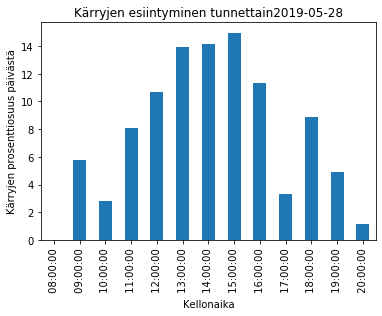

In [18]:
import pylab as plt

nodes.groupby("timestamp").esintyvyysprosentti.mean().plot.bar(title='Kärryjen esiintyminen tunnettain' + str(database.timestamp.dt.date.iloc[0]))
plt.ylabel('Kärryjen prosenttiosuus päivästä')
plt.xlabel('Kellonaika')
